# Evaluating Seasonal Climate Biases: A Comparison of Model Outputs with EOBS Observations

This notebook analyzes seasonal means and biases for temperature (`tas`) and precipitation (`pr`) using EOBS observational data and model outputs. 

The workflow includes:
- Loading and preprocessing datasets.
- Regridding datasets to a common grid for comparison.
- Computing seasonal means for both observations and model outputs.
- Calculating biases for temperature and precipitation.
- Visualizing the results using contour plots.

This analysis helps evaluate the performance of climate models in simulating seasonal temperature and precipitation patterns.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from warnings import warn

import cf_xarray as cfxr
import cordex as cx
import dask
import xarray as xr
import xesmf as xe
from dask.distributed import Client
from evaltools import obs
from evaltools.source import get_source_collection, open_and_sort
from evaltools.utils import short_iid

dask.config.set(scheduler="single-threaded")

In [3]:
client = Client(dashboard_address="localhost:8787", threads_per_worker=1)

In [4]:
add_fx = ["orog", "areacella", "sftlf"]


def add_bounds(ds):
    if "longitude" not in ds.cf.bounds and "latitude" not in ds.cf.bounds:
        ds = cx.transform_bounds(ds, trg_dims=("vertices_lon", "vertices_lat"))
    lon_bounds = ds.cf.get_bounds("longitude")
    lat_bounds = ds.cf.get_bounds("latitude")
    bounds_dim = [dim for dim in lon_bounds.dims if dim not in ds.indexes][0]
    # reshape bounds for xesmf
    ds = ds.assign_coords(
        lon_b=cfxr.bounds_to_vertices(
            lon_bounds, bounds_dim=bounds_dim, order="counterclockwise"
        ),
        lat_b=cfxr.bounds_to_vertices(
            lat_bounds, bounds_dim=bounds_dim, order="counterclockwise"
        ),
    )
    return ds


def mask_with_sftlf(ds, sftlf=None):
    if sftlf is None and "sftlf" in ds:
        sftlf = ds["sftlf"]
        for var in ds.data_vars:
            if var != "sftlf":
                ds[var] = ds[var].where(sftlf > 0)
        ds["mask"] = sftlf > 0
    else:
        warn(f"sftlf not found in dataset: {ds.source_id}")
    return ds


def open_datasets(
    variables,
    frequency="mon",
    mask=True,
    add_fx=None,
    merge_fx=True,
    add_missing_bounds=True,
    rewrite_grid=True,
    apply_fixes=True,
    **kwargs,
):
    cat = get_source_collection(variables, frequency, add_fx=add_fx, **kwargs)
    dsets = open_and_sort(cat, merge_fx=merge_fx, apply_fixes=apply_fixes)
    if rewrite_grid is True:
        for dset_id, ds in dsets.items():
            dsets[dset_id] = rewrite_coords(ds)
    if mask is True:
        for ds in dsets.values():
            mask_with_sftlf(ds)
    if add_missing_bounds is True:
        for dset_id, ds in dsets.items():
            dsets[dset_id] = add_bounds(ds)
    return dsets


def create_cordex_grid(domain_id):
    grid = cx.domain(domain_id, bounds=True, mip_era="CMIP6")
    # grid["lon"].attrs = {}
    # grid["vertices_lat"].attrs = {}
    lon_b = cfxr.bounds_to_vertices(
        grid.vertices_lon, bounds_dim="vertices", order="counterclockwise"
    )
    lat_b = cfxr.bounds_to_vertices(
        grid.vertices_lat, bounds_dim="vertices", order="counterclockwise"
    )
    return grid.assign_coords(lon_b=lon_b, lat_b=lat_b)


def create_regridder(source, target, method="bilinear"):
    regridder = xe.Regridder(source, target, method=method)
    return regridder


def regrid(ds, regridder, mask_after_regrid=True):
    ds_regrid = regridder(ds)
    if mask_after_regrid:
        for var in ds.data_vars:
            if var not in add_fx:
                ds_regrid[var] = ds_regrid[var].where(ds_regrid["mask"] > 0.0)
    return ds_regrid


def regrid_dsets(dsets, target_grid, method="bilinear"):
    for dset_id, ds in dsets.items():
        try:
            mapping = ds.cf["grid_mapping"].grid_mapping_name
        except KeyError as e:
            warn(f"KeyError: {e} for {dset_id}")
            mapping = "rotated_latitude_longitude"
        if mapping != "rotated_latitude_longitude":
            print(f"regridding {dset_id} with grid_mapping: {mapping}")
            regridder = create_regridder(ds, target_grid, method=method)
            print(regridder)
            dsets[dset_id] = regrid(ds, regridder)
    return dsets


def mask_invalid(ds, vars=None, threshold=0.1):
    if isinstance(vars, str):
        vars = [vars]
    if vars is None:
        var = list(ds.data_vars)
    for var in vars:
        var_nan = ds[var].isnull().sum(dim="time") / ds.time.size
        ds[var] = ds[var].where(var_nan < threshold)
    return ds


def rewrite_coords(ds, coords="all"):
    if ds.cf["grid_mapping"].grid_mapping_name == "rotated_latitude_longitude":
        ds = ds.cx.rewrite_coords(coords=coords)
    return ds


def height_temperature_correction(model_elev, obs_elev):
    """
    Height correction for temperature
    """
    lapse_rate = 0.0065  # °C per meter
    # Apply correction (adjust model temp to obs elevation)
    return lapse_rate * (obs_elev - model_elev)

In [5]:
dsets = open_datasets(
    ["tas", "pr"],
    # source_id=['CCLM6-0-1-URB-ESG'],
    frequency="mon",
    mip_era="CMIP6",
    add_fx=add_fx,
    add_missing_bounds=True,
    rewrite_grid=True,
    apply_fixes=True,
)

Found: ['ALARO1-SFX', 'CCLM6-0-1-URB', 'CCLM6-0-1-URB-ESG', 'CNRM-ALADIN64E1', 'HCLIM43-ALADIN', 'ICON-CLM-202407-1-1', 'RACMO23E', 'REMO2020-2-2', 'REMO2020-2-2-MR2', 'RegCM5-0'] for variables: ['tas', 'pr']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.MPI-ESM1-2-HR.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.CNRM-ESM2-1.ssp370.r1i1p1f2.RACMO23E.v1-r1.fx.v20241216
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.MIROC6.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.NorESM2-MM.ssp126.r1i1p1f1.RACMO23E.v1-r1.fx.v20241216
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM

Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.EC-Earth3-Veg.ssp126.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.fx.v20241009
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505
Warning for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
Found 57 datasets
decoding dataset CORDEX-CMIP6.EUR-12.KNMI.MPI-ESM1-2-HR.ssp370.r1i1p1f1.RACMO23E.v1-r1.fx.v20241216
Found 57 datasets
decoding d

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
  warnings.warn(message)


Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.ssp370.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328 will be ignored...
Fix failed for CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415.
Dataset CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.fx.v20250415 will be ignored...


Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: "Receive multiple variables for key 'grid_mapping': ['rotated_pole', 'crs']. Expected only one. Please pass a list ['grid_mapping'] instead to get all variables matching 'grid_mapping'."
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Found multiple grid mapping variables ['rotated_pole', 'crs']
Warning for CORDEX-CMIP6.EUR-12.CLMcom-KUL.ERA5.evaluation.r1i1p1f1.CCLM6-0-1-URB-ESG.v1-r1.fx.v20250409: Using crs as the grid mapping variable name. Please check the dataset.
Fix failed for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
Dataset CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v2025

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:69: UserWarning: Grid mapping name latitude_longitude is not supported for CORDEX-CMIP6.EUR-12.CNRM-MF.CNRM-ESM2-1.historical.r1i1p1f2.CNRM-ALADIN64E1.v1-r1.fx.v20250328
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/evaltools/fix.py:88: UserWarning: Grid mapping has (198.0, 39.25) which is inconsistent with (-162.0, 39.25) for EUR-12 and CORDEX-CMIP6.EUR-12.ICTP.ERA5.evaluation.r1i1p1f1.RegCM5-0.v1-r1.mon.v20250415.
  warnings.warn(message)


merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2-MR2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.fx.v20241009
merging CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.mon.v20241120 with CORDEX-CMIP6.EUR-12.GERICS.ERA5.evaluation.r1i1p1f1.REMO2020-2-2.v1-r1.fx.v20241120
merging CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.mon.v20240920 with CORDEX-CMIP6.EUR-12.CLMcom-Hereon.ERA5.evaluation.r1i1p1f1.ICON-CLM-202407-1-1.v1-r1.fx.v20240920
merging CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.fx.v20241205
merging CORDEX-CMIP6.EUR-12.CLMc

In [6]:
rotated_grid = create_cordex_grid("EUR-12")
dsets = regrid_dsets(dsets, rotated_grid, method="bilinear")

regridding CORDEX-CMIP6.EUR-12.RMIB-UGent.ERA5.evaluation.r1i1p1f1.ALARO1-SFX.v1-r1.mon.v20241009 with grid_mapping: lambert_conformal_conic


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_483x483_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (483, 483) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False


regridding CORDEX-CMIP6.EUR-12.HCLIMcom-SMHI.ERA5.evaluation.r1i1p1f1.HCLIM43-ALADIN.v1-r1.mon.v20241205 with grid_mapping: lambert_conformal_conic


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX-CMIP6.EUR-12.CNRM-MF.ERA5.evaluation.r1i1p1f1.CNRM-ALADIN64E1.v1-r1.mon.v20250505 with grid_mapping: lambert_conformal_conic


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False


In [7]:
period = slice("1980", "2020")

eobs_tg = obs.eobs(variables=["tg"], add_mask=False).sel(time=period)
eobs_tg = mask_invalid(eobs_tg, vars="tg", threshold=0.1)
eobs_rr = obs.eobs(variables=["rr"], add_mask=False).sel(time=period)
eobs_rr = mask_invalid(eobs_rr, vars="rr", threshold=0.1)
eobs = xr.merge([eobs_tg, eobs_rr], join="override")

In [8]:
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder_bil = xe.Regridder(
    eobs, rotated_grid, method="bilinear", unmapped_to_nan=True
)
regridder_cons = xe.Regridder(
    eobs, rotated_grid, method="conservative_normed", unmapped_to_nan=True
)

In [9]:
eobs_on_rotated = xr.merge(
    [regridder_bil(eobs[["tg", "elevation"]]), regridder_cons(eobs[["rr"]])],
    join="override",
)

In [10]:
def seasonal_mean(da):
    """Optimized function to calculate seasonal averages from time series of monthly means

    based on: https://xarray.pydata.org/en/stable/examples/monthly-means.html
    """
    # Get number od days for each month
    month_length = da.time.dt.days_in_month
    # Calculate the weights by grouping by 'time.season'.
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    # np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (
        (da * weights).groupby("time.season").sum(dim="time", skipna=True, min_count=1)
    )

In [11]:
%%time

eobs_seasmean = seasonal_mean(eobs_on_rotated[["tg", "rr"]].sel(time=period)).compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 37.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 6.05 s, sys: 2.09 s, total: 8.14 s
Wall time: 1min 19s


In [12]:
%%time

bias_tas = {
    dset_id: (
        seasonal_mean(ds["tas"].sel(time=period)).compute()
        + height_temperature_correction(ds.orog, eobs_on_rotated.elevation)
        - (eobs_seasmean.tg + 273.15)
    ).rename("tas")
    for dset_id, ds in dsets.items()
}

CPU times: user 20.3 s, sys: 2.7 s, total: 23 s
Wall time: 32.9 s


In [13]:
%%time

bias_pr = {
    dset_id: (
        100
        * (
            seasonal_mean(ds["pr"].sel(time=period)).compute() * 86400
            - eobs_seasmean.rr
        )
        / eobs_seasmean.rr
        # Assign NaN where observed precipitation is zero
    ).rename("pr")
    for dset_id, ds in dsets.items()
}

CPU times: user 20.4 s, sys: 2.79 s, total: 23.2 s
Wall time: 32.4 s


In [14]:
seasonal_bias_tas = xr.concat(
    list(bias_tas.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["institution_id", "source_id"], delimiter="-"),
                bias_tas.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

seasonal_bias_pr = xr.concat(
    list(bias_pr.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["institution_id", "source_id"], delimiter="-"),
                bias_pr.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

seasonal_bias = xr.merge(
    [seasonal_bias_tas, seasonal_bias_pr], compat="override", join="override"
)

In [15]:
%%time
seasonal_bias_ = seasonal_bias.compute()

/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 74.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 145 ms, sys: 150 ms, total: 295 ms
Wall time: 478 ms


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/cf_xarray/accessor.py:718: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/cf_xarray/accessor.py:719: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
<frozen _collections_abc>:899: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more c

aspect: 0.9716981132075472
0 0 0 DJF GERICS-REMO2020-2-2-MR2


0 1 4 DJF RMIB-UGent-ALARO1-SFX
0 2 8 DJF GERICS-REMO2020-2-2
0 3 12 DJF CLMcom-Hereon-ICON-CLM-202407-1-1


0 4 16 DJF HCLIMcom-SMHI-HCLIM43-ALADIN
0 5 20 DJF CLMcom-CMCC-CCLM6-0-1-URB
0 6 24 DJF CNRM-MF-CNRM-ALADIN64E1


0 7 28 DJF KNMI-RACMO23E
1 0 1 JJA GERICS-REMO2020-2-2-MR2
1 1 5 JJA RMIB-UGent-ALARO1-SFX


1 2 9 JJA GERICS-REMO2020-2-2
1 3 13 JJA CLMcom-Hereon-ICON-CLM-202407-1-1
1 4 17 JJA HCLIMcom-SMHI-HCLIM43-ALADIN


1 5 21 JJA CLMcom-CMCC-CCLM6-0-1-URB
1 6 25 JJA CNRM-MF-CNRM-ALADIN64E1
1 7 29 JJA KNMI-RACMO23E


2 0 2 MAM GERICS-REMO2020-2-2-MR2
2 1 6 MAM RMIB-UGent-ALARO1-SFX
2 2 10 MAM GERICS-REMO2020-2-2


2 3 14 MAM CLMcom-Hereon-ICON-CLM-202407-1-1
2 4 18 MAM HCLIMcom-SMHI-HCLIM43-ALADIN
2 5 22 MAM CLMcom-CMCC-CCLM6-0-1-URB


2 6 26 MAM CNRM-MF-CNRM-ALADIN64E1
2 7 30 MAM KNMI-RACMO23E
3 0 3 SON GERICS-REMO2020-2-2-MR2


3 1 7 SON RMIB-UGent-ALARO1-SFX
3 2 11 SON GERICS-REMO2020-2-2
3 3 15 SON CLMcom-Hereon-ICON-CLM-202407-1-1


3 4 19 SON HCLIMcom-SMHI-HCLIM43-ALADIN
3 5 23 SON CLMcom-CMCC-CCLM6-0-1-URB
3 6 27 SON CNRM-MF-CNRM-ALADIN64E1


3 7 31 SON KNMI-RACMO23E
aspect: 0.9716981132075472
0 0 0 DJF GERICS-REMO2020-2-2-MR2


/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/cf_xarray/accessor.py:718: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  unused_keys = set(attribute.keys()) - set(inverted)
/mnt/CORDEX_CMIP6_tmp/user_tmp/lbuntemeyer/conda_envs/evalbook-remote/lib/python3.13/site-packages/cf_xarray/accessor.py:719: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for key, value in attribute.items():
<frozen _collections_abc>:899: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more c

0 1 4 DJF RMIB-UGent-ALARO1-SFX
0 2 8 DJF GERICS-REMO2020-2-2
0 3 12 DJF CLMcom-Hereon-ICON-CLM-202407-1-1
0 4 16 DJF HCLIMcom-SMHI-HCLIM43-ALADIN


0 5 20 DJF CLMcom-CMCC-CCLM6-0-1-URB
0 6 24 DJF CNRM-MF-CNRM-ALADIN64E1
0 7 28 DJF KNMI-RACMO23E


1 0 1 JJA GERICS-REMO2020-2-2-MR2
1 1 5 JJA RMIB-UGent-ALARO1-SFX
1 2 9 JJA GERICS-REMO2020-2-2


1 3 13 JJA CLMcom-Hereon-ICON-CLM-202407-1-1
1 4 17 JJA HCLIMcom-SMHI-HCLIM43-ALADIN
1 5 21 JJA CLMcom-CMCC-CCLM6-0-1-URB


1 6 25 JJA CNRM-MF-CNRM-ALADIN64E1
1 7 29 JJA KNMI-RACMO23E
2 0 2 MAM GERICS-REMO2020-2-2-MR2
2 1 6 MAM RMIB-UGent-ALARO1-SFX


2 2 10 MAM GERICS-REMO2020-2-2
2 3 14 MAM CLMcom-Hereon-ICON-CLM-202407-1-1
2 4 18 MAM HCLIMcom-SMHI-HCLIM43-ALADIN


2 5 22 MAM CLMcom-CMCC-CCLM6-0-1-URB
2 6 26 MAM CNRM-MF-CNRM-ALADIN64E1
2 7 30 MAM KNMI-RACMO23E
3 0 3 SON GERICS-REMO2020-2-2-MR2


3 1 7 SON RMIB-UGent-ALARO1-SFX
3 2 11 SON GERICS-REMO2020-2-2
3 3 15 SON CLMcom-Hereon-ICON-CLM-202407-1-1


3 4 19 SON HCLIMcom-SMHI-HCLIM43-ALADIN
3 5 23 SON CLMcom-CMCC-CCLM6-0-1-URB
3 6 27 SON CNRM-MF-CNRM-ALADIN64E1
3 7 31 SON KNMI-RACMO23E


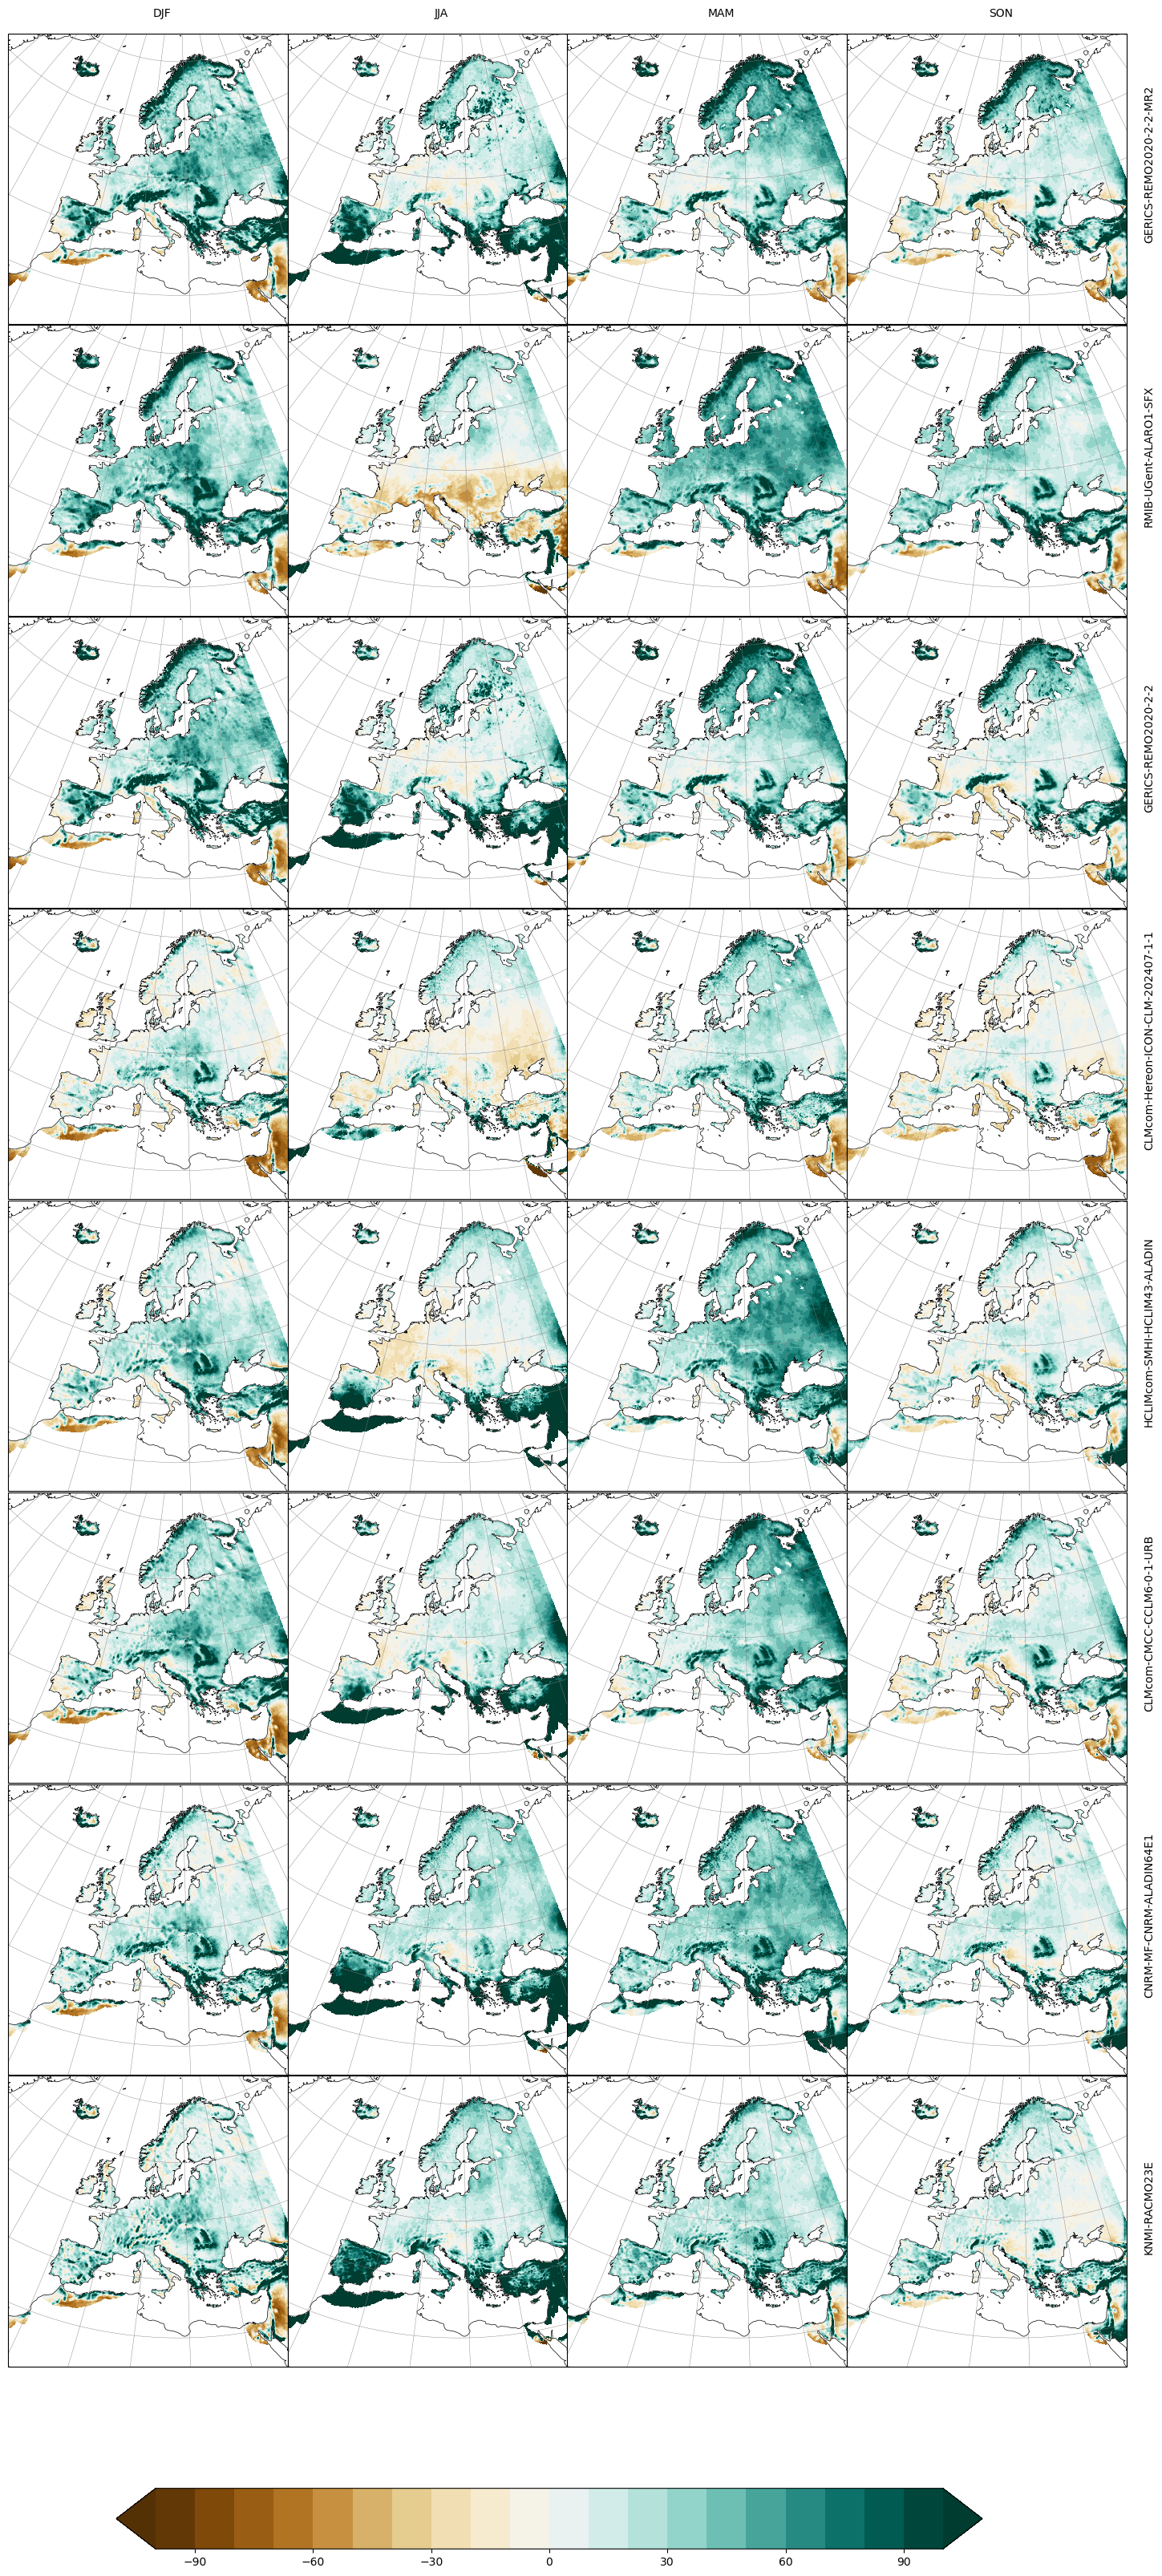

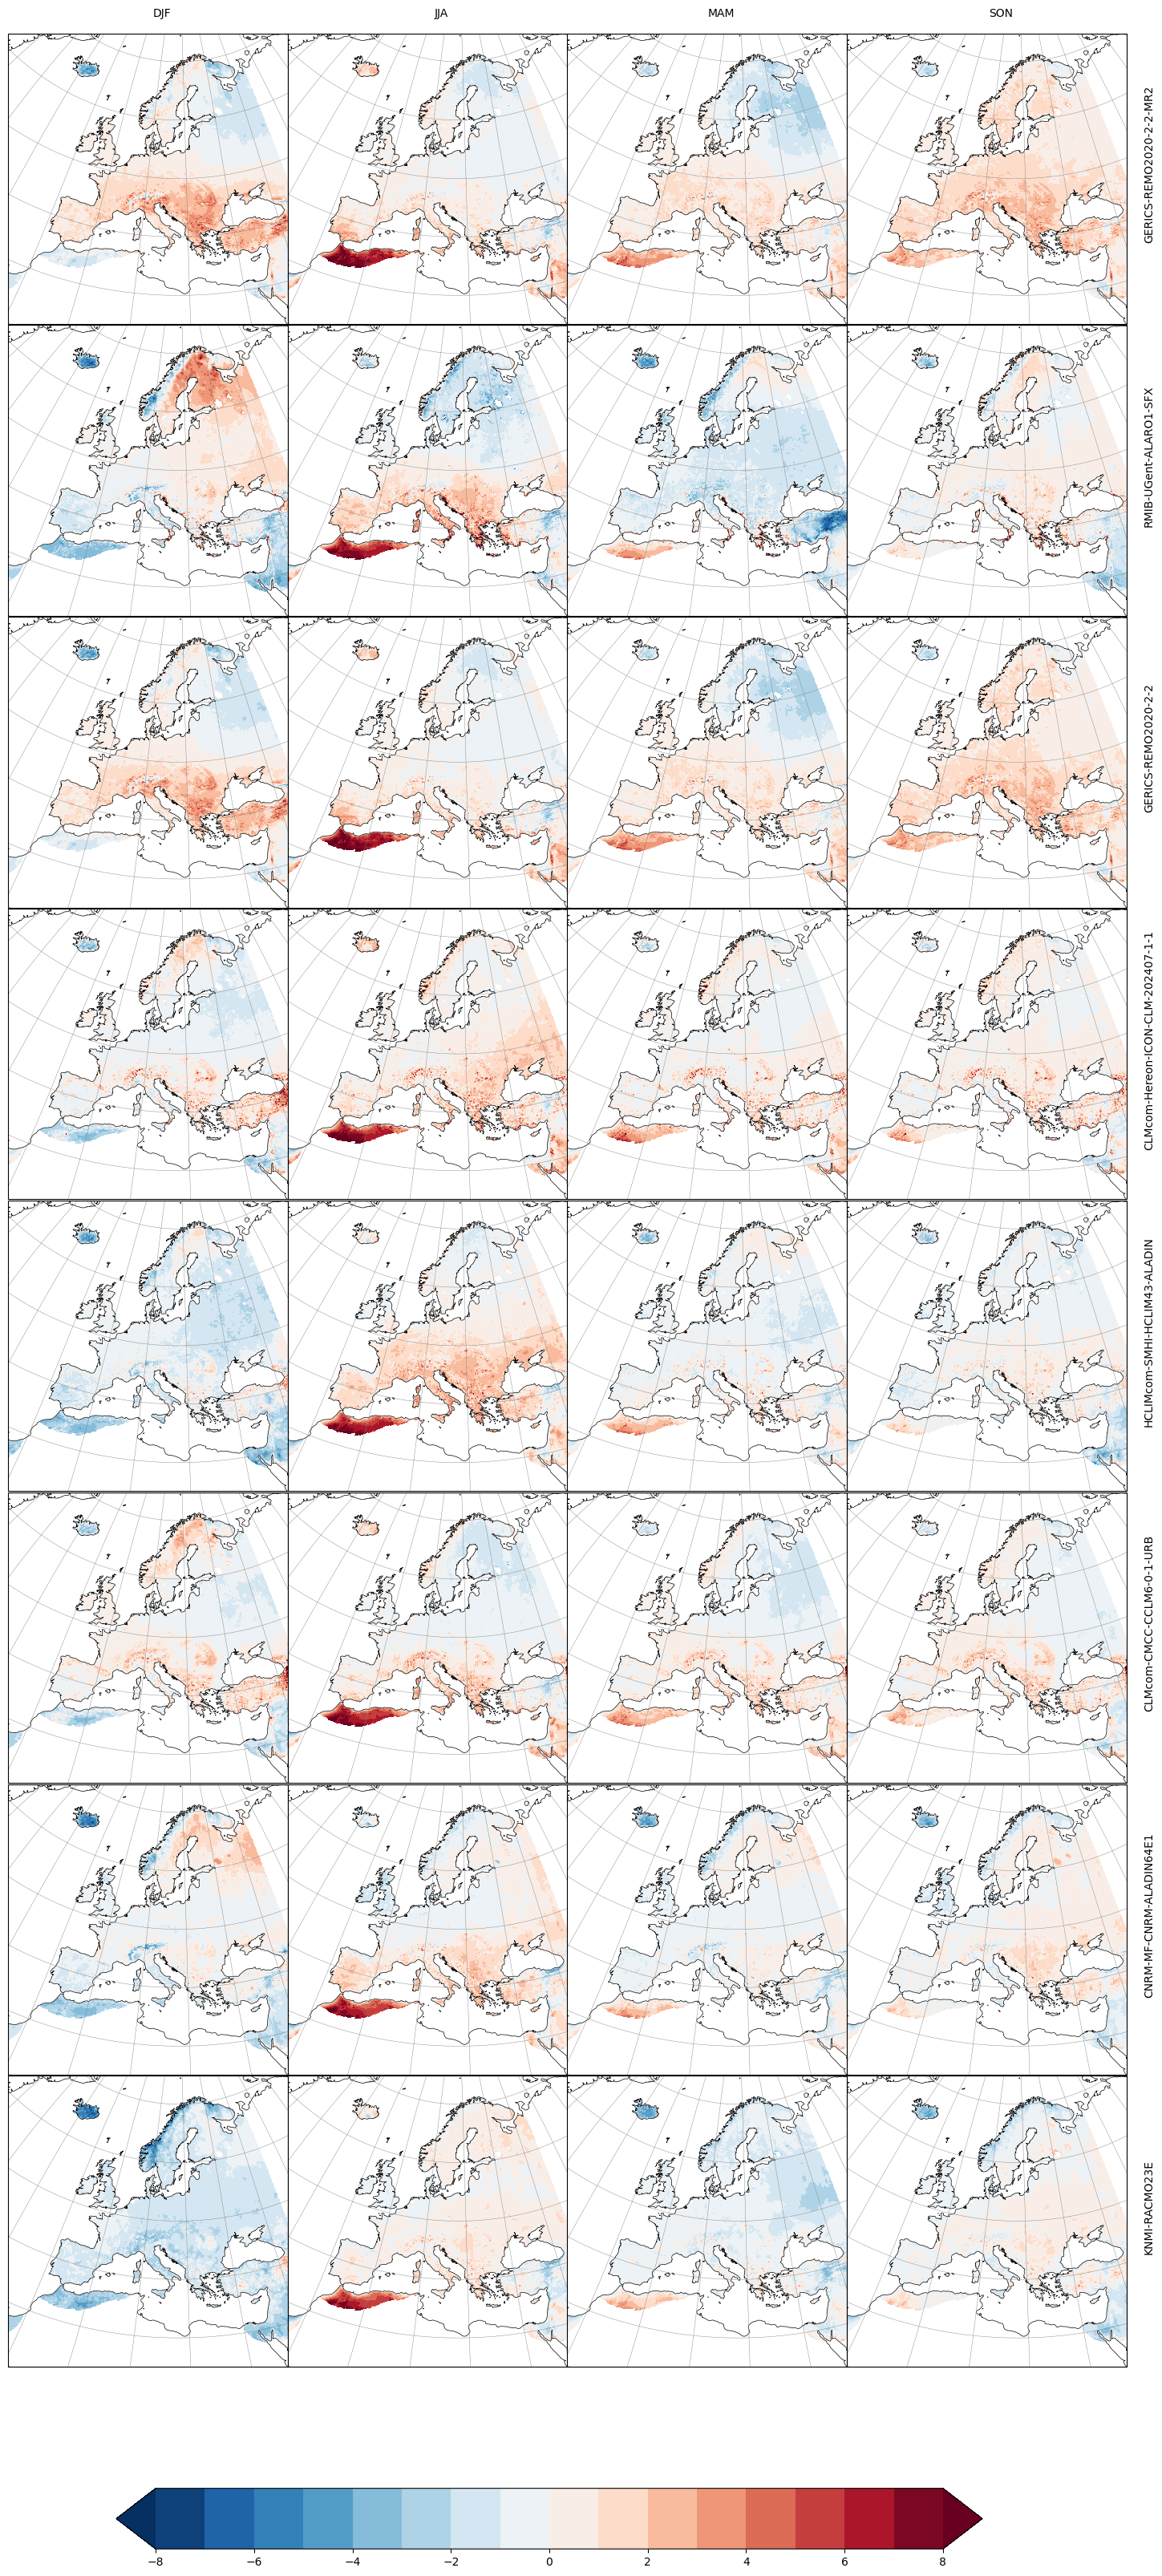

In [16]:
import numpy as np


def plot_all(ds, plot_var, levels, cmap):
    import matplotlib.pyplot as plt
    from cartopy import crs as ccrs
    from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

    nrows = ds.dset_id.size
    ncols = ds.season.size

    aspect = ds.cf.dims["Y"] / ds.cf.dims["X"]
    print(f"aspect: {aspect}")
    data = ds[plot_var]

    pole_latitude = rotated_grid.cf["grid_mapping"].grid_north_pole_latitude
    pole_longitude = rotated_grid.cf["grid_mapping"].grid_north_pole_longitude
    transform = ccrs.RotatedPole(
        pole_latitude=pole_latitude, pole_longitude=pole_longitude
    )
    projection = transform

    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(18, 18 * 1.05 * nrows / ncols),
        sharex=True,
        sharey=True,
        gridspec_kw={"wspace": 0, "hspace": 0},
        #  aspect_ratio=0.97,
    )

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    axs = axs.flatten()

    # Loop over all of the models
    for i, season in enumerate(ds.season.values):
        for j, dset_id in enumerate(ds.dset_id.values):
            pos = i + j * ncols
            print(i, j, pos, season, dset_id)
            # Select the week 1 forecast from the specified model
            data = ds[plot_var].isel(season=i, dset_id=j)

            # Contour plot
            cs = axs[pos].contourf(
                ds.cf["X"],
                ds.cf["Y"],
                data,
                transform=transform,
                # Define the levels for contourf
                levels=levels,
                # cmap="coolwarm",
                extend="both",
                cmap=cmap,
            )

            axs[pos].set_aspect(round(aspect, 3))

            # Draw the coastines for each subplot
            axs[pos].coastlines(resolution="50m", color="black", linewidth=0.5)

            axs[pos].gridlines(
                draw_labels=False,
                linewidth=0.3,
                color="gray",
                xlocs=range(-180, 180, 10),
                ylocs=range(-90, 90, 10),
            )

            # Longitude labels
            # https://stackoverflow.com/questions/35479508/cartopy-set-xlabel-set-ylabel-not-ticklabels
            if i == 3:
                axs[pos].text(
                    1.1,
                    0.55,
                    dset_id,
                    va="bottom",
                    ha="center",
                    rotation="vertical",
                    rotation_mode="anchor",
                    transform=axs[pos].transAxes,
                )
            if j == 0:
                axs[pos].text(
                    0.55,
                    1.05,
                    season,
                    va="bottom",
                    ha="center",
                    rotation="horizontal",
                    rotation_mode="anchor",
                    transform=axs[pos].transAxes,
                )

            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()
            axs[pos].xaxis.set_major_formatter(lon_formatter)
            axs[pos].yaxis.set_major_formatter(lat_formatter)

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.02])

    # Draw the colorbar
    fig.colorbar(cs, cax=cbar_ax, orientation="horizontal")


plot_var = "pr"
levels = np.arange(-100, 110, 10)  #
cmap = "BrBG"
plot_all(seasonal_bias_[[plot_var]], plot_var, levels, cmap)

plot_var = "tas"
levels = np.arange(-8, 9, 1)
cmap = "RdBu_r"
plot_all(seasonal_bias_[[plot_var]], plot_var, levels, cmap)